# End to End Time Series Analysis: Daily Energy Consumption

- [Data Source](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/): This is the daily energy consumption dataset for Germany. 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Load the Data

The original data goes back to 2006 but we will use only the lat two years 2016-2017

In [2]:
data = pd.read_csv('opsd_germany_daily.csv', usecols=[0,1])
data.Date = pd.to_datetime(data.Date)
y = data.copy().set_index(data.Date).drop('Date', axis=1)['2016':]
y.head()

,Consumption
Date,
2016-01-01,1060.366
2016-01-02,1192.698
2016-01-03,1179.282
2016-01-04,1456.294
2016-01-05,1506.737


# Visualize the Data

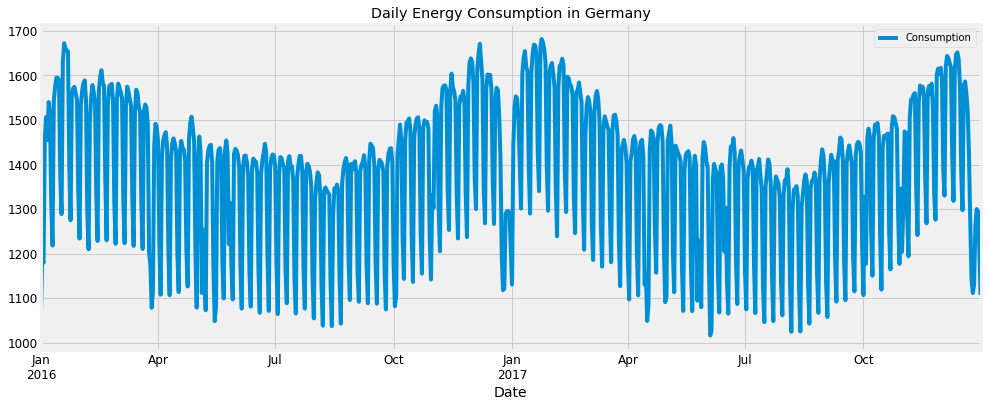

In [3]:
# work with average weekly demand, resample weekly at every Monday
#y = ys.resample('W-MON').mean()
_ = y.plot(figsize=(15, 6), title='Daily Energy Consumption in Germany')

# Series Decomposition

We can use a time-series decomposition method to decompose our time series into three distinct components: 
- trend 
- seasonality
- noise

In [4]:
#ys = y.diff().dropna()

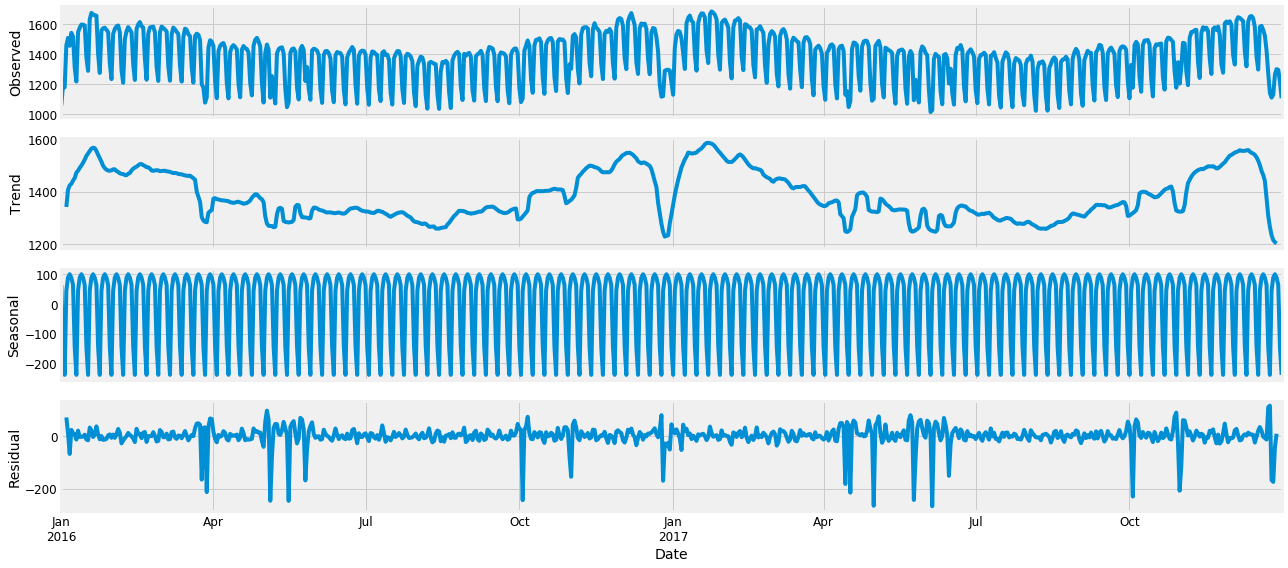

In [5]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

The plot clearly shows that the data is not stationary. 
- There is a clear trend, decreasing from Jan-Jul, and increasing from Jul-Dec. This suggests we will need to perform differencing
- There is seasonality, quite consistent across years?
- Noise term seems to have higher in some month usually between April and July, Jan, Oct, we may need to perform some sort of transformation

# Fitting with SARIMA

We can use a classic method for time series analysis **SARIMA** which stands for Seasonal Auto Regressive Integrated Moving Average. **SARIMA** models are written **SARIMA(p, d, q, P, D, Q)** where 

- **p** is the order of the Auto Regressive component (how past consumptions affect present consumption)
- **d** is the order of the difference needed to remove systematic trends in the data
- **q** is the order of the Moving Average component (noise effects, what we don't know)
- **P, D, Q** are equivalent order for the seasonal effects in energy consumption 

So the question is how do we determine p, d, q, P, D, Q? 

- ## Determine orders using Grid Search?

In [6]:
def grid_search(y, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

aic = grid_search(y, pdq, seasonal_pdq)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:12642.311794247464
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:11608.085519693966
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:8549.899531215913
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:8323.211735231576
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:8586.691306665187
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:8409.68612119666
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:8381.073062313953
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:8318.052740695317
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:11661.799167947813
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:10808.158085786317
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:8303.769183409717
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:7998.184466662171
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:8353.344891591609
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:8078.8926625042695
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:8104.958337549629
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:7998.698205466322
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:9373.610610700709
ARIM

In [7]:
#get the model with minimum aic : min(dict, key=dict.get) will return the key with minimum value in dict
print("Model with Minimum AIC {}".format(min(aic, key=aic.get)))

Model with Minimum AIC (1, 1, 1, 0, 1, 1, 7)


--- 
We learn from **Grid Search** that the best model based on AIC is SARIMA(1,1,1)*(0,1,1,7). 
But grid search can be tidious and time consuming. We can also use other concepts such as the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)

---

## Determine orders using ACF and PACF

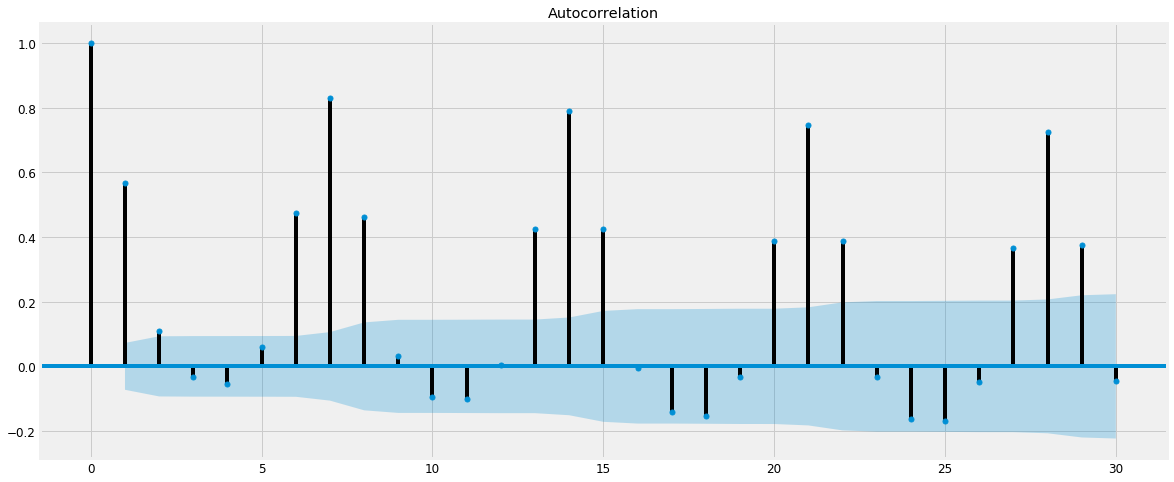

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y, lags=30)
plt.show()

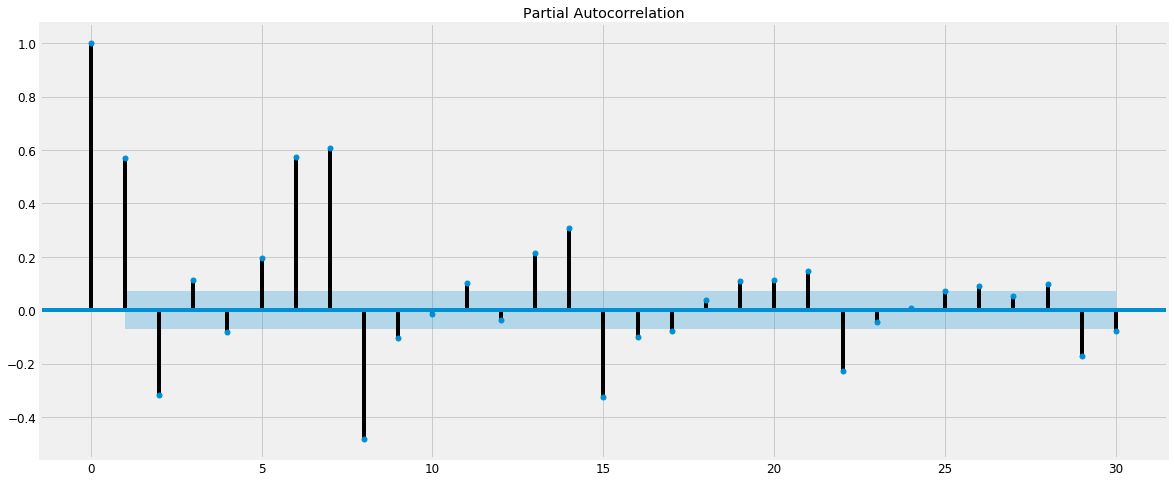

In [9]:
plot_pacf(y, lags=30)
plt.show()

**From the Autocorrelation Plot ACF**  
- We see a cut-off structure, after lag 2 (suggests possible q values are 0, 1, 2)
- We see a repeating (seasonal) effect after 7 days (suggest s = 7)  

**From the Partial Autocorrelation Plot ACF** 
- It's not clear if we have a cut-off structure, but we see one or two significant lags at the start of each period (suggests possible p values are 0, 1, 2)
- We see a repeating (seasonal) effect after 7 days (suggest s = 7)  

**How do we determine d?**  
Well we can take the first order difference and see if that removes the trend. In this case it does. As shown below the trend component is more or less stationary.

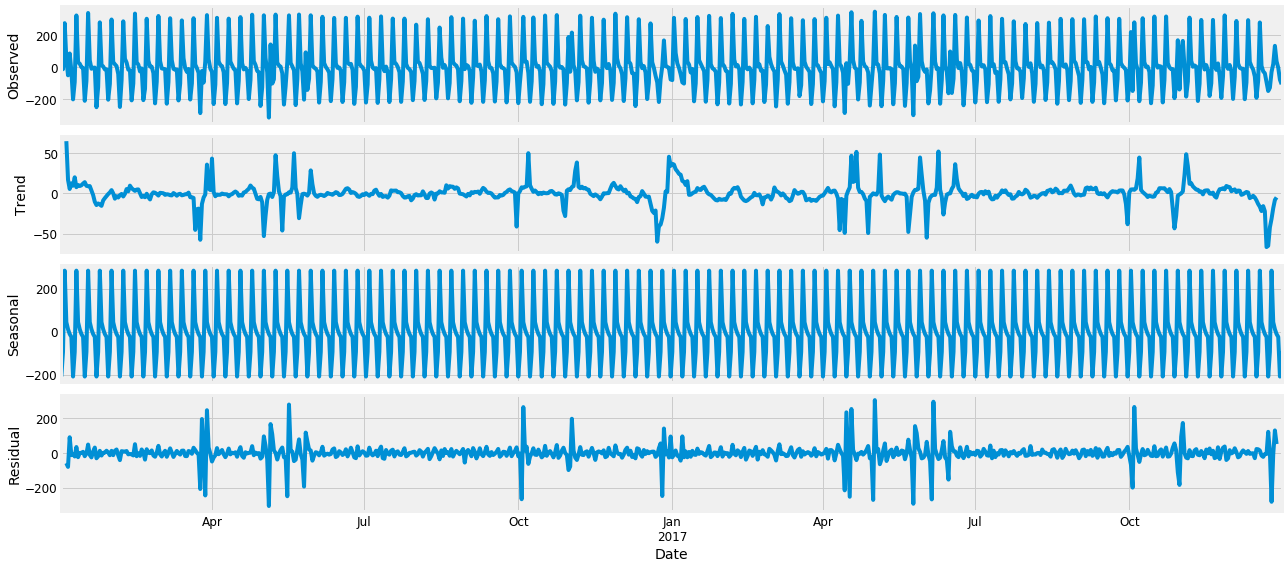

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y.diff().dropna(), model='additive')
fig = decomposition.plot()

**How do we determine P,D,Q?**   

For now let's just go with the grid search method

## Fitting the Model

In [11]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4751      0.039     12.240      0.000       0.399       0.551
ma.L1         -0.8244      0.030    -27.112      0.000      -0.884      -0.765
ma.S.L7       -1.0000     11.981     -0.083      0.933     -24.482      22.482
sigma2      2784.5641   3.34e+04      0.083      0.934   -6.27e+04    6.82e+04


The above summary shows that
- The estimated coefficient for the AR component (0.4751) is significant since the p-value is small
- The estimated paramter for the MA component is significant
- The estimated stantard deviation of the noise term is not significant. This i a problem. We may need some transformation on the data

## Model Diagnostic

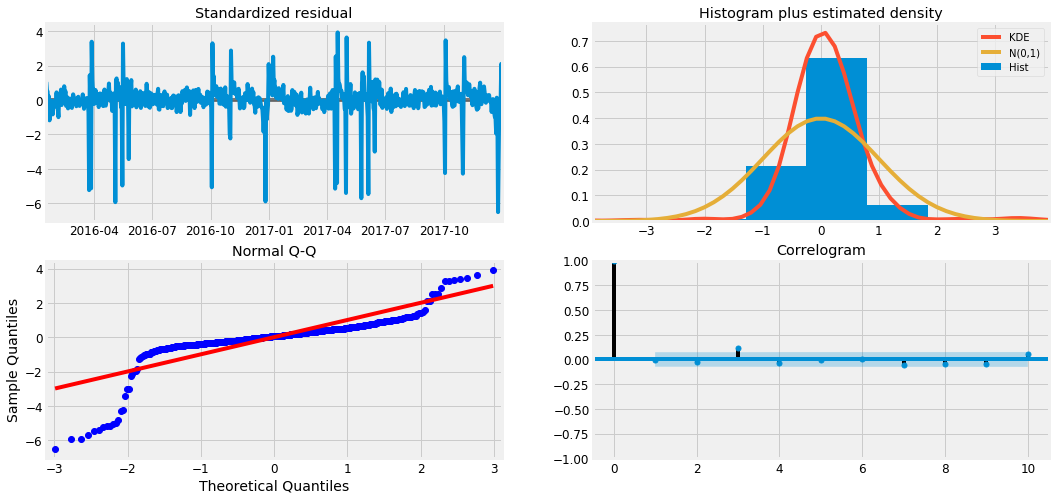

In [12]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Again, the Q-Q plot clearly suggests that the residuals are not normally distributed. The residuals also appear to have non-constant variance. Again, a log transform may be needed in this case but we will not do that here.

## Validating 

Let do some forecasts starting on 2016–01–01 to the end of the data.

In [13]:
y['2016'].head()

,Consumption
Date,
2016-01-01,1060.366
2016-01-02,1192.698
2016-01-03,1179.282
2016-01-04,1456.294
2016-01-05,1506.737


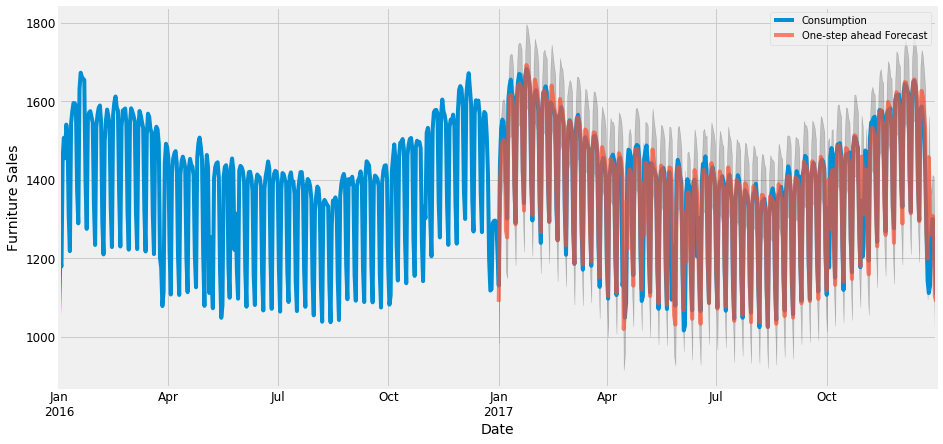

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Evaluation

In [15]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':].values.flatten()
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean = {}, MSE = {}, RMSE = {}'.format(round(y_truth.mean(), 2), round(mse, 2), round(mse**(0.5),2)))

Mean = 1382.84, MSE = 3106.45, RMSE = 55.74


## Forecasting the Feature

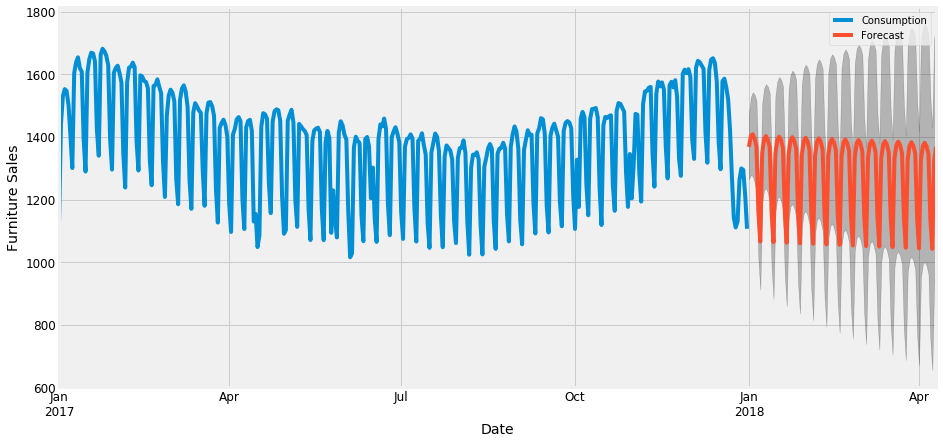

In [16]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y['2017':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

This model kinda captures the seasonal effect but clearly needs to be improved. As mentioned above, our residuals are not normaly distributed and we have not really done much to select the best possible model. However, the steps highlighted here are typically what will be done to fit time series data and predict the future.